In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

## Feature Engineering
1. Datos faltantes
2. Outliers
3. Ruido
4. Transformación de datos (transformacion del rango; ej. log(1+x), box-cox)

### Datos faltantes
Comparando imputación por media / mediana con técnicas más avanzadas como por ejemplo IterativeImputer

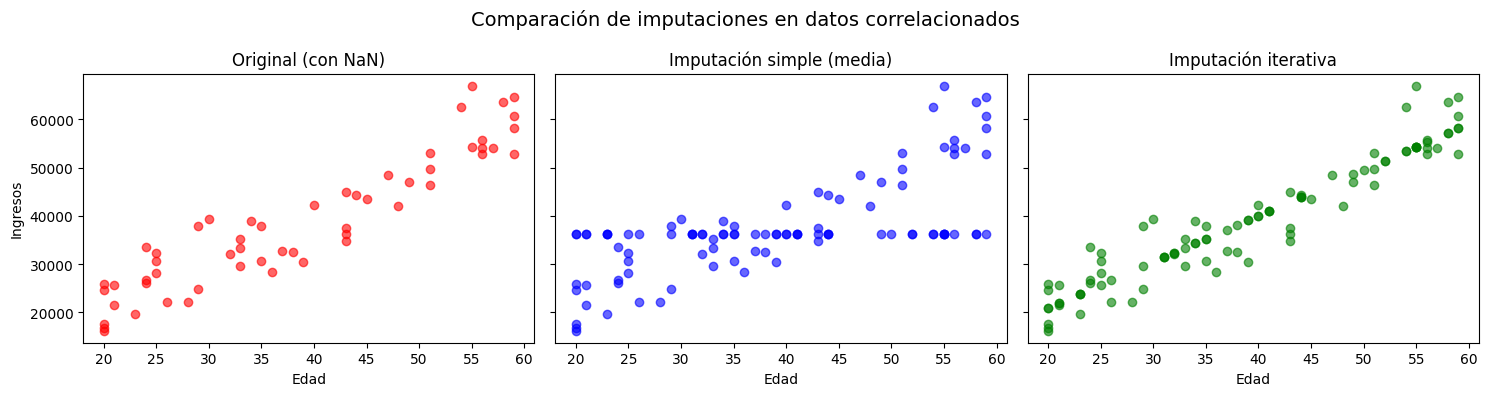

In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Simulamos un dataset con correlación clara entre edad e ingresos
np.random.seed(0)
n = 100
edad = np.random.randint(20, 60, size=n)
ingresos = edad * 1000 + np.random.normal(0, 5000, size=n)  # correlación fuerte

df = pd.DataFrame({"edad": edad, "ingresos": ingresos})

# Introducimos valores perdidos artificialmente
df.loc[np.random.choice(df.index, 45, replace=False), "ingresos"] = np.nan

# Imputación simple
df_simple = df.copy()
df_simple["ingresos"] = df_simple["ingresos"].fillna(df["ingresos"].mean())

# Imputación iterativa
imp = IterativeImputer(max_iter=10, random_state=42)
df_iter = df.copy()
df_iter[["edad", "ingresos"]] = imp.fit_transform(df_iter[["edad", "ingresos"]])

# Comparación visual
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].scatter(df["edad"], df["ingresos"], color="red", alpha=0.6)
axes[0].set_title("Original (con NaN)")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Ingresos")

axes[1].scatter(df_simple["edad"], df_simple["ingresos"], color="blue", alpha=0.6)
axes[1].set_title("Imputación simple (media)")
axes[1].set_xlabel("Edad")

axes[2].scatter(df_iter["edad"], df_iter["ingresos"], color="green", alpha=0.6)
axes[2].set_title("Imputación iterativa")
axes[2].set_xlabel("Edad")

plt.suptitle("Comparación de imputaciones en datos correlacionados", fontsize=14)
plt.tight_layout()
plt.show()

## Datos faltantes: Cuándo usar cada uno (regla práctica)

- Pocas NA y patrón simple → SimpleImputer (median en numéricas; most_frequent en categóricas) + add_indicator=True.
- Relaciones no lineales suaves o datos en “nubes” locales → KNNImputer (recuerda escalar).
- Muchas columnas con NA y variables correlacionadas → IterativeImputer (posible sample_posterior=True para reflejar incertidumbre).
- Siempre que la ausencia pueda importar → añade indicadores de missingness (add_indicator=True o MissingIndicator en un Pipeline).

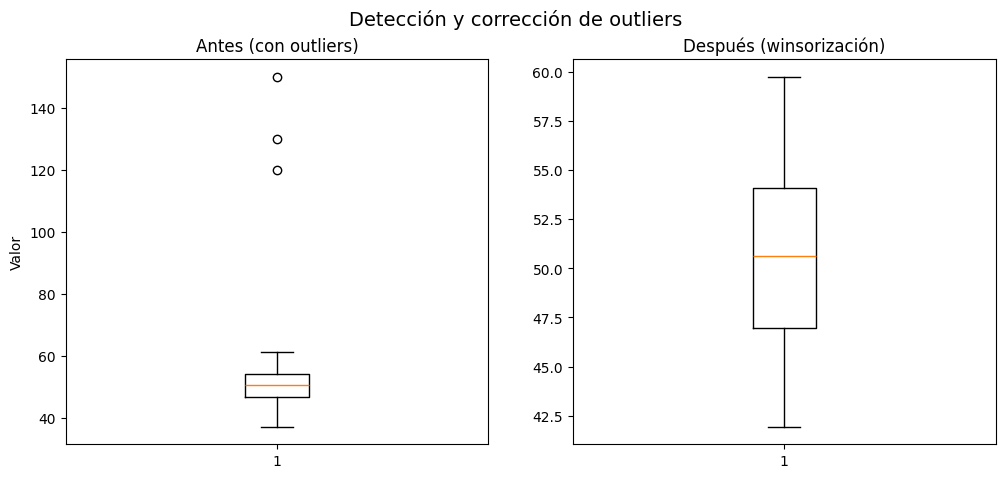

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mstats, zscore

# Dataset con outliers
np.random.seed(0)
data = np.random.normal(50, 5, 100)   # distribución normal
data = np.append(data, [120, 130, 150])  # añadimos outliers
df = pd.DataFrame({"valor": data})

# Winsorización (recorta el 5% en cada cola)
df_winsor = df.copy()
df_winsor["valor"] = mstats.winsorize(df["valor"], limits=[0.05, 0.05])

# Gráfico comparativo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot(df["valor"])
axes[0].set_title("Antes (con outliers)")
axes[0].set_ylabel("Valor")

axes[1].boxplot(df_winsor["valor"])
axes[1].set_title("Después (winsorización)")

plt.suptitle("Detección y corrección de outliers", fontsize=14)
plt.show()

### Ejemplo de winsorización 
``df_winsor["valor"] = mstats.winsorize(df["valor"], limits=[0.05, 0.05])`` 


- Percentiles por calcular:

    5% → posición 103 × 0.05 = 5.15 → se interpola entre el 5º y 6º valor ordenado.

    95% → posición 103 × 0.95 = 97.85 → se interpola entre el 98º y 99º valor ordenado.

- Como la distribución base es normal ~50 con sd pequeña (≈5), y solo añadiste 3 outliers grandes (120, 130, 150):

    El percentil 5 (P5) ≈ 45.9 (bajito respecto a la media, se deduce por simetría de la normal simulada y tu Q1=46.97).

    El percentil 95 (P95) ≈ 58.9–59 (coincide casi con tu valor en el índice 97 = 58.93).

- Como la distribución base es normal ~50 con sd pequeña (≈5), y solo añadiste 3 outliers grandes (120, 130, 150):

    El percentil 5 (P5) ≈ 45.9 (bajito respecto a la media, se deduce por simetría de la normal simulada y tu Q1=46.97).

    El percentil 95 (P95) ≈ 58.9–59 (coincide casi con tu valor en el índice 97 = 58.93).

## Ruido

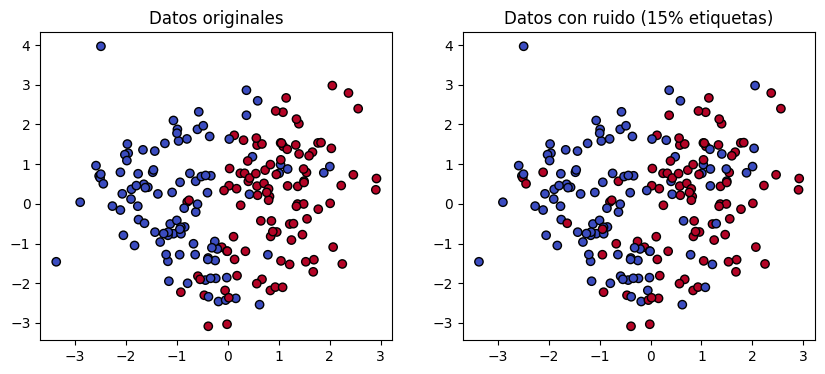

Accuracy sin ruido: 0.94
Accuracy con ruido: 0.90


In [15]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Dataset sencillo
X, y = make_classification(n_samples=200, n_features=2, 
                           n_informative=2, n_redundant=0,
                           random_state=42)

# Introducir ruido en las etiquetas (flip del 15%)
rng = np.random.RandomState(42)
n_noise = int(0.15 * len(y))
noise_idx = rng.choice(len(y), size=n_noise, replace=False)
y_noisy = y.copy()
y_noisy[noise_idx] = 1 - y_noisy[noise_idx]

# Visualización de ruido
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k")
plt.title("Datos originales")

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=y_noisy, cmap="coolwarm", edgecolor="k")
plt.title("Datos con ruido (15% etiquetas)")
plt.show()

# Comparación de desempeño
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_noisy, _, y_train_noisy, _ = train_test_split(X, y_noisy, random_state=0)

acc_clean = LogisticRegression().fit(X_train, y_train).score(X_test, y_test)
acc_noisy = LogisticRegression().fit(X_train_noisy, y_train_noisy).score(X_test, y_test)

print(f"Accuracy sin ruido: {acc_clean:.2f}")
print(f"Accuracy con ruido: {acc_noisy:.2f}")

Número de sospechosos detectados: 51
Primeros 10 índices sospechosos: [ 9 13 15 16 23 28 30 36 37 39]


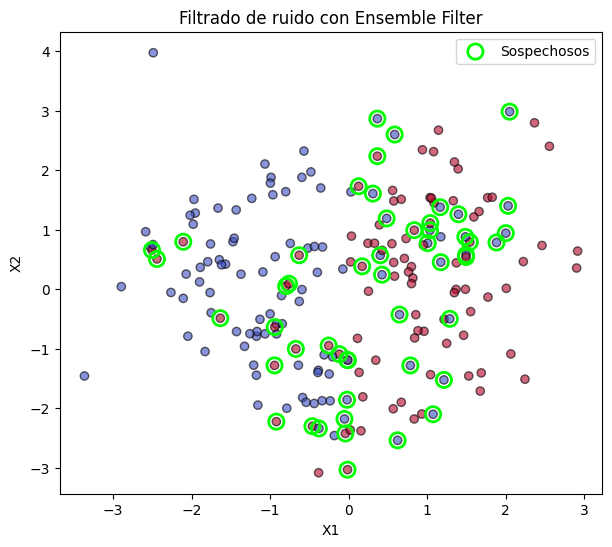

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 2. Ensemble Filter: votación con 3 clasificadores
ensemble = VotingClassifier(
    estimators=[
        ("tree", DecisionTreeClassifier(random_state=0)),
        ("knn", KNeighborsClassifier(n_neighbors=5)),
        ("lda", LinearDiscriminantAnalysis())
    ],
    voting="hard"
)

# 3. Predicciones cruzadas
y_pred = cross_val_predict(ensemble, X, y_noisy, cv=5)

# 4. Identificar posibles ruidosos
suspect_idx = np.where(y_pred != y_noisy)[0]

print("Número de sospechosos detectados:", len(suspect_idx))
print("Primeros 10 índices sospechosos:", suspect_idx[:10])

# Puntos originales con etiquetas ruidosas
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=y_noisy, cmap="coolwarm", edgecolor="k", alpha=0.6)

# Resaltar en verde los sospechosos detectados por Ensemble Filter
plt.scatter(X[suspect_idx,0], X[suspect_idx,1], 
            facecolor="none", edgecolor="lime", s=120, linewidth=2, label="Sospechosos")

plt.title("Filtrado de ruido con Cross-Validated Committees Filter (CVCF)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

## Transformación de datos
La log-transform es un “atajo manual” que suele funcionar bien en datos sesgados a la derecha.

El Box-Cox es una versión sistemática que elige automáticamente la mejor transformación para cumplir supuestos de normalidad.

Ambas son herramientas que sirven para hacer válidos los métodos de inferencia estadística paramétrica cuando los datos en crudo no cumplen los supuestos.

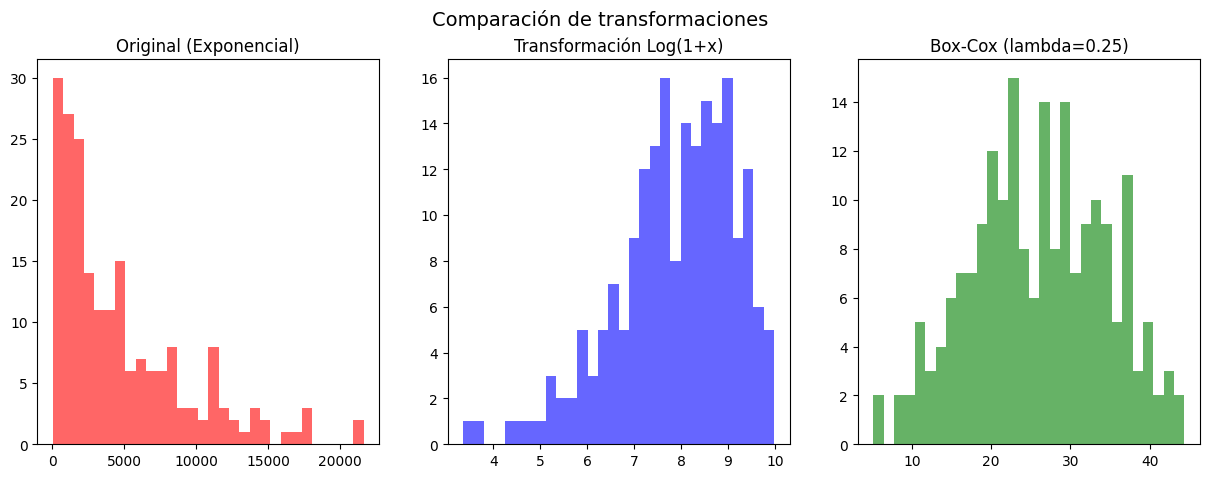

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Simular datos sesgados (distribución exponencial)
np.random.seed(42)
data = np.random.exponential(scale=5000, size=200)
df = pd.DataFrame({"ingresos": data})

# Log-transform
df["ingresos_log"] = np.log1p(df["ingresos"])  # log(1+x) para evitar log(0)

# Box-Cox (requiere datos positivos)
fitted_data, fitted_lambda = stats.boxcox(df["ingresos"])

# Gráficos
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].hist(df["ingresos"], bins=30, color="red", alpha=0.6)
axes[0].set_title("Original (Exponencial)")
axes[1].hist(df["ingresos_log"], bins=30, color="blue", alpha=0.6)
axes[1].set_title("Transformación Log(1+x)")
axes[2].hist(fitted_data, bins=30, color="green", alpha=0.6)
axes[2].set_title(f"Box-Cox (lambda={fitted_lambda:.2f})")
plt.suptitle("Comparación de transformaciones", fontsize=14)
plt.show()